In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sps

In [3]:
dataset = pd.read_csv('data/spam.data.txt', sep=" ", header=None)
dataset = dataset.sample(frac=1)
dataset.columns = ['word_freq_make', 'word_freq_address', 'word_freq_all', 
                   'word_freq_3d', 'word_freq_our', 'word_freq_over', 
                   'word_freq_remove', 'word_freq_internet', 'word_freq_order', 
                   'word_freq_mail', 'word_freq_receive', 'word_freq_will', 
                   'word_freq_people', 'word_freq_report', 'word_freq_addresses', 
                   'word_freq_free', 'word_freq_business', 'word_freq_email', 
                   'word_freq_you', 'word_freq_credit', 'word_freq_your', 
                   'word_freq_font', 'word_freq_000', 'word_freq_money', 
                   'word_freq_hp', 'word_freq_hpl', 'word_freq_george', 
                   'word_freq_650', 'word_freq_lab', 'word_freq_labs', 
                   'word_freq_telnet', 'word_freq_857', 'word_freq_data', 
                   'word_freq_415', 'word_freq_85', 'word_freq_technology', 
                   'word_freq_1999', 'word_freq_parts', 'word_freq_pm', 
                   'word_freq_direct', 'word_freq_cs', 'word_freq_meeting', 
                   'word_freq_original', 'word_freq_project', 'word_freq_re',
                   'word_freq_edu', 'word_freq_table', 'word_freq_conference',
                   'char_freq_;', 'char_freq_(', 'char_freq_[', 'char_freq_!', 
                   'char_freq_$', 'char_freq_#', 'capital_run_length_average', 
                   'capital_run_length_longest', 'capital_run_length_total', 
                   'target']


In [4]:
# Method to find the entropy
def findEntropy(target):
    elems, counts = np.unique(target, return_counts = True)
    entropy = np.sum([(-counts[i]/np.sum(counts))*np.log2(counts[i]/np.sum(counts)) for i in range(len(elems))])
    return entropy

In [5]:
# Method used to find the information gain using the split attribute
def findInfoGain(data, split_attr, target="target"):
    t_entropy = findEntropy(data[target])
    v, counts= np.unique(data[split_attr], return_counts=True)
    w_entropy = np.sum([(counts[i]/np.sum(counts)) * findEntropy(
                          data.where(data[split_attr] == v[i]).dropna()[target]) 
                            for i in range(len(v))])
    info_gain = t_entropy - w_entropy
    return info_gain

In [6]:
# Method to generate the number of features used for best split in Random Forest
def gen_num_of_features(f, f_choice):
  if f_choice == 1:
    return np.int(np.sqrt(len(f))) # Square root of total #features
  else:
    return len(f) # all features considered

In [7]:
# Method implements the ID3 Algorithm
def ID3(data, orig_data, features, f_choice, target="target", parent = None):    
    # If all target_values have the same value, return this value
    if len(np.unique(data[target])) <= 1:
        return np.unique(data[target])[0]
    
    # If the dataset is empty, return the mode target feature value in the original dataset
    elif len(data)==0:
        return np.unique(orig_data[target])[np.argmax(np.unique(orig_data[target], return_counts=True)[1])]
    
    # If the feature space is empty, return the mode target feature value of the direct parent node 
    elif len(features) == 0:
        return parent
    
    # If none of the above holds true, grow the tree!
    else:
        #Set the default value for parent as the mode target feature value of the current node
        parent = np.unique(data[target])[np.argmax(np.unique(data[target], return_counts=True)[1])]
        # generate the number of features to select as per given choice
        m = gen_num_of_features(features, f_choice)
        # choosing best features for split
        features = np.random.choice(features, size=m, replace=False)
        # Return the information gain values for the features in the dataset
        item_values = [findInfoGain(data, feature, target) for feature in features]
        best_feature_index = np.argmax(item_values)
        best_feature = features[best_feature_index]
        
        # Create the tree with the name of the best_feature 
        tree = {best_feature:{}}

        # Remove the feature with the best inforamtion gain from the feature space
        features = [i for i in features if i != best_feature]
        
        # Grow a branch under the root node for each possible value of the root node feature
        for value in np.unique(data[best_feature]):
            # value = value
            # Split the dataset along the value of the feature with the most information gain and create sub datasets
            sub_data = data.where(data[best_feature] == value).dropna()            
            # recursively call ID3 algorithm for each of those sub datasets with the new parameters
            subtree = ID3(sub_data, dataset, features, f_choice, target, parent)            
            #Add the sub tree, grown from the sub dataset to the tree under the root node
            tree[best_feature][value] = subtree
            
        return tree

In [8]:
# Method used for predicting a query for a given tree
def predict(query, tree, default = 0):
    for key in list(query.keys()):
        if key in list(tree.keys()):
            try:
                result = tree[key][query[key]] 
            except:
                return default
            result = tree[key][query[key]]
            if isinstance(result,dict):
                return predict(query,result)
            else:
                return result

In [9]:
# Method used for splitting dataset into train and test
def train_test_split(dataset):
    train_data = dataset.iloc[:round(0.7*len(dataset))].reset_index(drop=True)
    test_data = dataset.iloc[round(0.7*len(dataset)):].reset_index(drop=True)
    return train_data, test_data

In [10]:
train_data, test_data = train_test_split(dataset)

In [11]:
train_data

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,word_freq_receive,word_freq_will,word_freq_people,word_freq_report,word_freq_addresses,word_freq_free,word_freq_business,word_freq_email,word_freq_you,word_freq_credit,word_freq_your,word_freq_font,word_freq_000,word_freq_money,word_freq_hp,word_freq_hpl,word_freq_george,word_freq_650,word_freq_lab,word_freq_labs,word_freq_telnet,word_freq_857,word_freq_data,word_freq_415,word_freq_85,word_freq_technology,word_freq_1999,word_freq_parts,word_freq_pm,word_freq_direct,word_freq_cs,word_freq_meeting,word_freq_original,word_freq_project,word_freq_re,word_freq_edu,word_freq_table,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,target
0,0.00,0.00,0.85,0.0,0.42,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.42,0.00,0.00,2.14,0.0,1.28,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.42,0.00,0.0,0.0,0.000,0.159,0.0,1.117,0.000,0.000,1.206,7,117,1
1,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,2.08,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.000,0.000,0.0,0.000,0.000,0.000,1.428,4,10,0
2,2.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,2.00,2.00,0.00,0.0,0.0,0.00,0.00,0.00,2.00,0.0,8.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.000,0.000,0.0,0.000,0.000,0.000,5.888,29,53,0
3,0.36,0.00,1.09,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.72,1.81,0.0,0.0,0.00,0.00,0.00,0.72,0.0,1.09,0.0,0.0,0.72,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.063,0.126,0.0,0.063,0.126,0.000,2.562,35,123,1
4,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.60,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.000,0.102,0.0,0.102,0.720,0.000,4.512,43,185,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3216,0.00,1.03,0.00,0.0,1.03,0.00,1.03,0.51,0.00,0.51,0.00,1.03,0.00,0.0,0.0,0.51,0.00,0.51,2.07,0.0,1.55,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.51,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.000,0.257,0.0,0.600,0.429,0.000,1.447,4,55,1
3217,0.00,0.58,0.58,0.0,0.00,0.00,0.00,0.58,0.58,7.55,0.58,1.16,0.00,0.0,0.0,0.00,0.58,0.00,4.06,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.000,0.192,0.0,0.192,0.000,0.096,1.526,10,58,1
3218,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.81,0.00,0.00,2.45,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.81,0.0,0.0,0.0,0.0,0.81,0.0,0.0,0.81,0.81,0.0,0.0,0.000,0.000,0.0,0.000,0.000,0.000,1.684,5,64,0
3219,0.00,0.00,0.21,0.0,0.00,0.21,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,1.95,0.0,0.21,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.131,0.175,0.0,0.000,0.000,0.000,1.000,1,68,0


In [12]:
test_data

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,word_freq_receive,word_freq_will,word_freq_people,word_freq_report,word_freq_addresses,word_freq_free,word_freq_business,word_freq_email,word_freq_you,word_freq_credit,word_freq_your,word_freq_font,word_freq_000,word_freq_money,word_freq_hp,word_freq_hpl,word_freq_george,word_freq_650,word_freq_lab,word_freq_labs,word_freq_telnet,word_freq_857,word_freq_data,word_freq_415,word_freq_85,word_freq_technology,word_freq_1999,word_freq_parts,word_freq_pm,word_freq_direct,word_freq_cs,word_freq_meeting,word_freq_original,word_freq_project,word_freq_re,word_freq_edu,word_freq_table,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,target
0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,4.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,2.363,11,26,1
1,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,2.5,0.0,0.00,0.00,0.00,7.50,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,2.50,0.00,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,2.142,5,15,0
2,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,2.70,0.00,0.0,0.0,0.00,0.00,0.00,2.70,0.00,2.70,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.000,0.000,0.000,0.444,0.000,0.0,2.800,7,28,0
3,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,9.09,4.54,4.54,4.54,4.54,4.54,4.54,4.54,0.0,4.54,4.54,4.54,0.0,0.0,0.0,4.54,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.000,1.169,0.000,0.000,0.000,0.0,3.100,11,31,0
4,0.00,0.00,0.00,0.0,0.76,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.76,0.00,0.00,0.00,0.00,0.0,0.0,0.00,2.30,0.76,0.00,0.00,0.00,1.53,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,2.300,7,138,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1375,0.00,0.95,0.95,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.47,0.47,1.90,0.0,0.0,0.47,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.47,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.066,0.200,0.000,0.267,0.000,0.0,4.180,45,464,1
1376,0.00,0.66,0.66,0.0,1.33,0.33,0.33,0.0,0.33,0.00,0.33,0.33,0.00,0.0,0.0,0.33,0.66,1.00,1.00,1.00,2.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.66,0.00,0.0,0.0,0.000,0.266,0.000,0.372,0.159,0.0,1.894,14,161,1
1377,0.00,0.00,0.42,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.21,0.0,0.0,0.21,0.00,0.21,2.14,0.00,0.42,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.21,0.21,0.0,0.0,0.42,0.21,0.0,0.0,0.000,0.078,0.039,0.039,0.000,0.0,1.292,6,106,0
1378,0.00,0.00,2.04,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,2.04,0.00,0.00,0.00,0.0,0.0,0.00,4.08,2.04,0.00,2.04,0.00,2.04,2.04,0.00,0.0,0.00,2.04,2.04,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.000,0.189,0.000,0.000,0.000,0.0,1.681,10,37,0


In [13]:
# Method used to train RF
def RandomForest_Train(dataset, n_Trees, m_choice):
    # Create a list in which the single forests are stored
    rf_sub_tree = []
    oob = pd.DataFrame(dataset)
    print(f"m: {gen_num_of_features(dataset.columns, m_choice)}")
    for i in range(n_Trees):
        # Create a number of bootstrap sampled datasets from the original dataset 
        bootstrap_sample = dataset.sample(frac=0.7, replace=True)
        oob = pd.concat([oob, bootstrap_sample]).drop_duplicates(keep=False)
        # bootstrap_train, bootstrap_test = train_test_split(bootstrap_sample)
        # Grow a tree model for each of the training data
        sub_tree = ID3( bootstrap_sample, bootstrap_sample, bootstrap_sample.drop(labels=['target'], axis=1).columns, m_choice)
        rf_sub_tree.append(sub_tree)

    return rf_sub_tree, oob

In [14]:
# Method to find all predictions
def RandomForest_Predict(query, rf, default=0):
    predictions = []
    for tree in rf:
        # Calls predict(.) method for each tree
        predictions.append(predict(query, tree, default))
    return sps.mode(predictions)[0][0]

In [15]:
# Method uses test dataset to find accuracy
def RandomForest_Test(data, rf):
    data['predictions'] = None
    for i in range(len(data)):
        query = data.iloc[i,:].drop('target').to_dict()
        data.loc[i, 'predictions'] = RandomForest_Predict(query, rf, default=0)
    err = sum(abs(data['predictions'] - data['target']))
    err = err/len(data)
    return err

In [16]:
# Method uses test dataset to find OBB error
def OOB_Err(data, rf):
    data.dropna(how='any', inplace=True)
    data.reset_index(inplace=True)
    data['predictions'] = None
    for i in data.index:
        query = data.iloc[i,:].drop('target').to_dict()
        data.loc[i, 'predictions'] = RandomForest_Predict(query, rf, default=0)
    err = sum(abs(data['predictions'] - data['target']))
    err = err/len(data)
    print('OOB Error: ', err*100,'%')

In [17]:
%time random_forest0, oob = RandomForest_Train(train_data, 5, 0)
err = RandomForest_Test(test_data, random_forest0)
acc = (1 - err)*100
print("==============================")
OOB_Err(oob, random_forest0)
print('Test Error: ', err*100, '%')
print('Test accuracy: ', acc, '%')
print("==============================")

m: 58
CPU times: user 10min 16s, sys: 9.57 s, total: 10min 25s
Wall time: 10min 22s
OOB Error:  19.518072289156628 %
Test Error:  35.79710144927537 %
Test accuracy:  64.20289855072463 %


m = All Features considered

In [18]:
%time random_forest1, oob = RandomForest_Train(train_data, 5, 1)
err = RandomForest_Test(test_data, random_forest1)
acc = (1 - err)*100
print("==============================")
OOB_Err(oob, random_forest1)
print('Test Error: ', err*100, '%')
print('Test accuracy: ', acc, '%')
print("==============================")


m: 7
CPU times: user 1min 8s, sys: 1.47 s, total: 1min 10s
Wall time: 1min 9s
OOB Error:  21.732157177225343 %
Test Error:  32.17391304347826 %
Test accuracy:  67.82608695652175 %


m = SQRT(features)

In [19]:
# Random Forests using sklearn

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate

# Encode the feature values which are strings to integers
for label in dataset.columns:
    dataset[label] = LabelEncoder().fit(dataset[label]).transform(dataset[label])

X = dataset.drop(['target'], axis=1)
Y = dataset['target']

#Instantiate the model with 100 trees and entropy as splitting criteria
Random_Forest_model = RandomForestClassifier(n_estimators=5,criterion="entropy")

#Cross validation
accuracy = cross_validate(Random_Forest_model, X, Y, cv=10)['test_score']
%time print('Sklearn RandomForestClassifier Accuracy: ',sum(accuracy)/len(accuracy)*100,'%')

Sklearn RandomForestClassifier Accuracy:  94.02310666792418 %
CPU times: user 1.2 ms, sys: 0 ns, total: 1.2 ms
Wall time: 934 µs


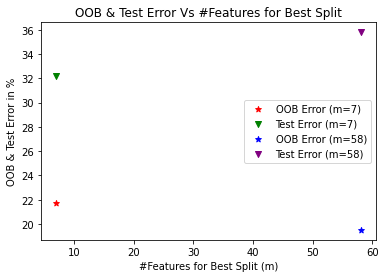

In [32]:
import matplotlib.pyplot as plt

e = [(21.73, 32.17), (19.51, 35.79)]
m = [7, 58]

plt.scatter(m[0], e[0][0], color='red', label=f'OOB Error (m=7)', marker= '*')
plt.scatter(m[0], e[0][1], color='green', label=f'Test Error (m=7)', marker='v')

plt.scatter(m[1], e[1][0], color='blue', label=f'OOB Error (m=58)', marker= '*')
plt.scatter(m[1], e[1][1], color='purple', label=f'Test Error (m=58)', marker='v')

plt.title('OOB & Test Error Vs #Features for Best Split')
plt.ylabel('OOB & Test Error in %')
plt.xlabel('#Features for Best Split (m)')
plt.legend()
plt.show()